# TGFBR2

In [1]:
import gpsea
from gpsea.analysis.predicate import PatientCategories
from gpsea.preprocessing import load_phenopacket_folder
from gpsea.preprocessing import configure_caching_cohort_creator
from gpsea.model import FeatureType, VariantEffect
from gpsea.view import CohortViewable
from gpsea.preprocessing import UniprotProteinMetadataService
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import VVMultiCoordinateService
from gpsea.view import ProteinVisualizable, ProteinVisualizer, ProteinViewable
import hpotk
import gpsea

from IPython.display import display, HTML

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.4.1.dev0


## TGFBR2

TGFBR2 codes for Transforming Growth Factor Beta Receptor 2, a transmembrane protein that has a protein kinase domain and forms a heterodimeric complex with TGF-beta receptor type-1. This complex binds TGF-beta.
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier.

In [2]:
gene_symbol = 'TGFBR2'
mane_tx_id = 'NM_003242.6'
mane_protein_id = 'NP_003233.4' # TGF-beta receptor type-2 isoform B precursor

# phenopackets
We load phenopackets representing the clinical features of individuals with pathogenic variants in TGFBR2 from release 0.1.19 of phenopacket-store.

In [3]:
from ppktstore.registry import configure_phenopacket_registry

phenopacket_store_release = '0.1.19'  # Update, if necessary
registry = configure_phenopacket_registry()

#with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
#    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

## TODO -- UPDATE TO USE phenopacket store after next release
from pyphetools.visualization import PhenopacketIngestor
pp_dir = '/Users/robin/GIT/phenopacket-store/notebooks/TGFBR2/phenopackets'
ingestor = PhenopacketIngestor(indir=pp_dir)
phenopackets = ingestor.get_phenopacket_list()


print(f'Loaded {len(phenopackets)} phenopackets')

[pyphetools] Ingested 47 GA4GH phenopackets.
Loaded 47 phenopackets


In [4]:
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
print(f'Loaded {len(cohort)} individuals')

Individuals Processed: 100%|██████████| 47/47 [00:00<00:00, 65.05individuals/s] 
Loaded 47 individuals


In [5]:
qc.summarize()

Validated under none policy
No errors or warnings were found


# Explorative analysis
We use functionality of GPSEA to visualize and list various aspects of the cohort.

In [6]:
from gpsea.view import CohortViewable

cv = CohortViewable(hpo)
report = cv.process(cohort, transcript_id=mane_tx_id)
display(HTML(report))

HPO Term,ID,Seen in n individuals
Aortic root aneurysm,HP:0002616,29
Joint hypermobility,HP:0001382,25
Arachnodactyly,HP:0001166,24
Scoliosis,HP:0002650,23
Arterial tortuosity,HP:0005116,20
Bifid uvula,HP:0000193,20
Malar flattening,HP:0000272,19
Epicanthus,HP:0000286,19
Disproportionate tall stature,HP:0001519,15
Dilatation of the cerebral artery,HP:0004944,14


In [7]:
from gpsea.model import ProteinMetadata
import os
if not os.path.exists("input/P37173.json"):
    raise FileNotFoundError("could not find downloaded UniProt JSON file")
protein_meta =  ProteinMetadata.from_uniprot_json(
            protein_id=mane_protein_id,
            label="transforming growth factor beta receptor 2",
            uniprot_json="input/P37173.json",
            protein_length=567,
        )

In [8]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizable, ProteinViewable


txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id)
pvis = ProteinVisualizable(tx_coordinates=tx_coordinates, protein_meta=protein_meta, cohort=cohort)

viewer = ProteinViewable()
html_prot = viewer.process(cohort, pvis)
display(HTML(html_prot))

Feature Name,Feature Type,Feature Coordinates,Variants in Feature
Protein kinase,domain,243 - 544,42
Sufficient for interaction with CLU,region,438 - 567,25


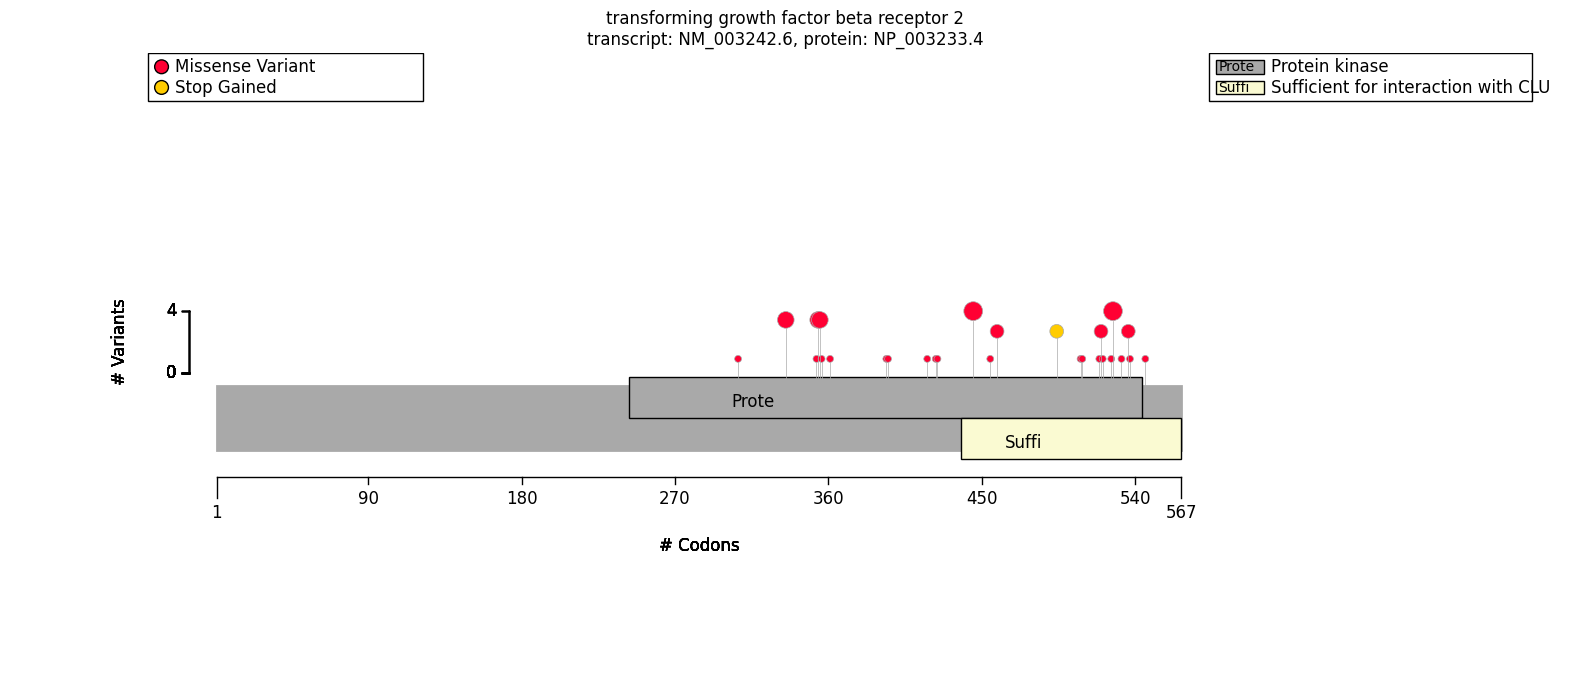

In [9]:
from gpsea.view import ProteinVisualizer

drawer = ProteinVisualizer()
ax = drawer.draw_fig(pvis=pvis)
fig = ax.get_figure()  # Get the figure object
fig.savefig('TGFBR2_uniprot_domains.png', format='png')  

In [10]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
report = viewer.process(cohort)
display(HTML(report))

Variant key,Variant (cDNA),Variant (protein),Effects,Count
3_30672189_30672189_T_A,c.1006T>A,p.Tyr336Asn,missense,3
3_30691477_30691477_C_T,c.1582C>T,p.Arg528Cys,missense,3
3_30672246_30672246_G_C,c.1063G>C,p.Ala355Pro,missense,3
3_30672250_30672250_G_C,c.1067G>C,p.Arg356Pro,missense,3
3_30674186_30674186_G_A,c.1336G>A,p.Asp446Asn,missense,2
3_30688470_30688470_C_T,c.1483C>T,p.Arg495Ter,stop gained,2
3_30691504_30691504_C_T,c.1609C>T,p.Arg537Cys,missense,2
3_30644921_30644921_C_T,c.263+6C>T,None,"splice donor, intronic",2
3_30691456_30691456_T_C,c.1561T>C,p.Trp521Arg,missense,2
3_30674186_30674186_G_T,c.1336G>T,p.Asp446Tyr,missense,2


In [11]:
from gpsea.model import VariantEffect
from gpsea.model.genome import Region

from gpsea.analysis.predicate.genotype import VariantPredicates, ModeOfInheritancePredicate

nterm_region = Region(start=1, end=370)
is_n_term = VariantPredicates.region(region=nterm_region, tx_id=mane_tx_id)

gt_predicate = ModeOfInheritancePredicate.autosomal_dominant(is_n_term)

/var/folders/hq/zttr8hjx127fgvh0bq7h4bc80000gn/T/ipykernel_27382/2994868913.py:9: DeprecationWarning: Use `gpsea.analysis.predicate.genotype.autosomal_dominant` instead
  gt_predicate = ModeOfInheritancePredicate.autosomal_dominant(is_n_term)


In [12]:
from gpsea.model import FeatureType
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [13]:
from gpsea.analysis.pcats.stats import FisherExactTest
from gpsea.analysis.mtc_filter import HpoMtcFilter

mtc_filter = HpoMtcFilter.default_filter(hpo=hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
statistic = FisherExactTest()

In [14]:
from gpsea.analysis.pcats import HpoTermAnalysis

analysis = HpoTermAnalysis(
    count_statistic=statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=0.05,
)

In [15]:
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)

In [16]:
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
report = viewer.process(result)
display(HTML(report))

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.2,10
HMF02,Skipping term because no genotype has more than one observed HPO count,3
HMF04,Skipping term because all genotypes have same HPO observed proportions,62
HMF05,Skipping term because one genotype had zero observations,12
HMF06,Skipping term with less than 7 observations (not powered for 2x2),95
HMF08,Skipping general term,61


In [17]:
from gpsea.view import summarize_hpo_analysis

report = summarize_hpo_analysis(hpo=hpo, result=result)
report

What is the genotype group                       HOM_REF            HET  \
                                                   Count Percent  Count   
Heterotropia [HP:0032012]                            1/9     11%    5/5   
Exodeviation [HP:0020049]                            1/9     11%    5/5   
Bifid uvula [HP:0000193]                            9/24     38%  11/12   
Exotropia [HP:0000577]                              1/15      7%    5/7   
Mitral valve prolapse [HP:0001634]                 11/17     65%    1/8   
Strabismus [HP:0000486]                             6/14     43%    5/5   
Malar flattening [HP:0000272]                      11/25     44%    8/9   
Patent ductus arteriosus [HP:0001643]               4/21     19%   6/11   
Atrial septal defect [HP:0001631]                   7/11     64%    2/9   
Blue sclerae [HP:0000592]                           3/14     21%    4/6   
Disproportionate tall stature [HP:0001519]         12/18     67%    3/9   
Epicanthus [HP:0000286]                            14/25     56%    5/5   
Proptosis [HP:0000520]                              5/12     42%    6/7   
Arterial tortuosity [HP:0005116]                   16/23     70%    7/7   
Pectus carinatum [HP:0000768]                       3/22     14%    2/4   
Aortic root aneurysm [HP:0002616]                  16/19     84%  13/13   
Patent foramen ovale [HP:0001655]                    4/9     44%    1/8   
Hypertelorism [HP:0000316]                          5/11     45%    5/6   
Cleft palate [HP:0000175]                           3/24     12%    3/9   
Micrognathia [HP:0000347]                          11/15     73%    0/1   
Soft skin [HP:0000977]                              4/15     27%    3/6   
Retrognathia [HP:0000278]                           5/11     45%   7/10   
Joint hypermobility [HP:0001382]                   16/22     73%   9/10   
Scoliosis [HP:0002650]                             14/21     67%   9/11   
Bicuspid aortic valve [HP:0001647]                   0/8      0%    2/8   
Pulmonary artery aneurysm [HP:0004937]               3/4     75%    3/8   
Atrophic scars [HP:0001075]                         9/15     60%    1/3   
Dilatation of the ductus arteriosus [HP:0030745]     1/7     14%    3/8   
Camptodactyly [HP:0012385]                           2/4     50%    2/7   
Pectus excavatum [HP:0000767]                      11/21     52%    1/4   
Genu valgum [HP:0002857]                            3/16     19%    2/7   
Dermal translucency [HP:0010648]                    6/16     38%    3/6   
Dilatation of the cerebral artery [HP:0004944]     11/20     55%    3/8   
Arachnodactyly [HP:0001166]                        18/27     67%   6/11   
Craniosynostosis [HP:0001363]                       2/11     18%    1/5   
Chiari malformation [HP:0002308]                     2/6     33%    2/5   
Dural ectasia [HP:0100775]                          5/14     36%    1/4   
High palate [HP:0000218]                           12/17     71%    1/1   
Talipes equinovarus [HP:0001762]                    8/18     44%    3/6   
Downslanted palpebral fissures [HP:0000494]         6/18     33%    1/2   
Descending thoracic aorta aneurysm [HP:0004959]      1/3     33%    3/7   
Hyperextensible skin [HP:0000974]                    3/6     50%    2/3   
Postaxial polydactyly [HP:0100259]                   1/4     25%    3/8   
Ascending aortic dissection [HP:0004933]            4/12     33%    0/2   
Dilated left subclavian artery [HP:0031252]          2/6     33%    1/5   

What is the genotype group                                                   \
                                                 Percent Corrected p values   
Heterotropia [HP:0032012]                           100%           0.048551   
Exodeviation [HP:0020049]                           100%           0.048551   
Bifid uvula [HP:0000193]                             92%           0.048551   
Exotropia [HP:0000577]                               71%           0.048551   


## Protein domains
We can manually create a ProteinMetadata object with greater resolution for protein domains.
The following information was gleaned from the UniProt entry for TGFBR2.
- signal peptide: 1-22
- extracellular: 23-166 
- transmembrane domain: 167-187.
- ATP binding site: 250-258
- Protein kinase: 244-544

In [20]:
import pandas as pd
domain_list = [ {"region": "signal peptide","category": "domain", "start": 1, "end": 22, },
            {"region": "extracellular", "category": "domain", "start": 23, "end": 166, },
            {"region": "transmembrane domain", "category": "domain", "start": 167, "end": 187, },
            {"region": "ATP binding site", "category": "domain", "start": 250, "end": 258, },
             {"region": "Protein kinase", "category": "domain", "start": 244, "end": 544, },
        ]
df = pd.DataFrame(domain_list)
manual_protein_meta = ProteinMetadata.from_feature_frame(
            protein_id=mane_protein_id,
            label="TGF-beta receptor type-2",
            features=df,
            protein_length=567,
        )

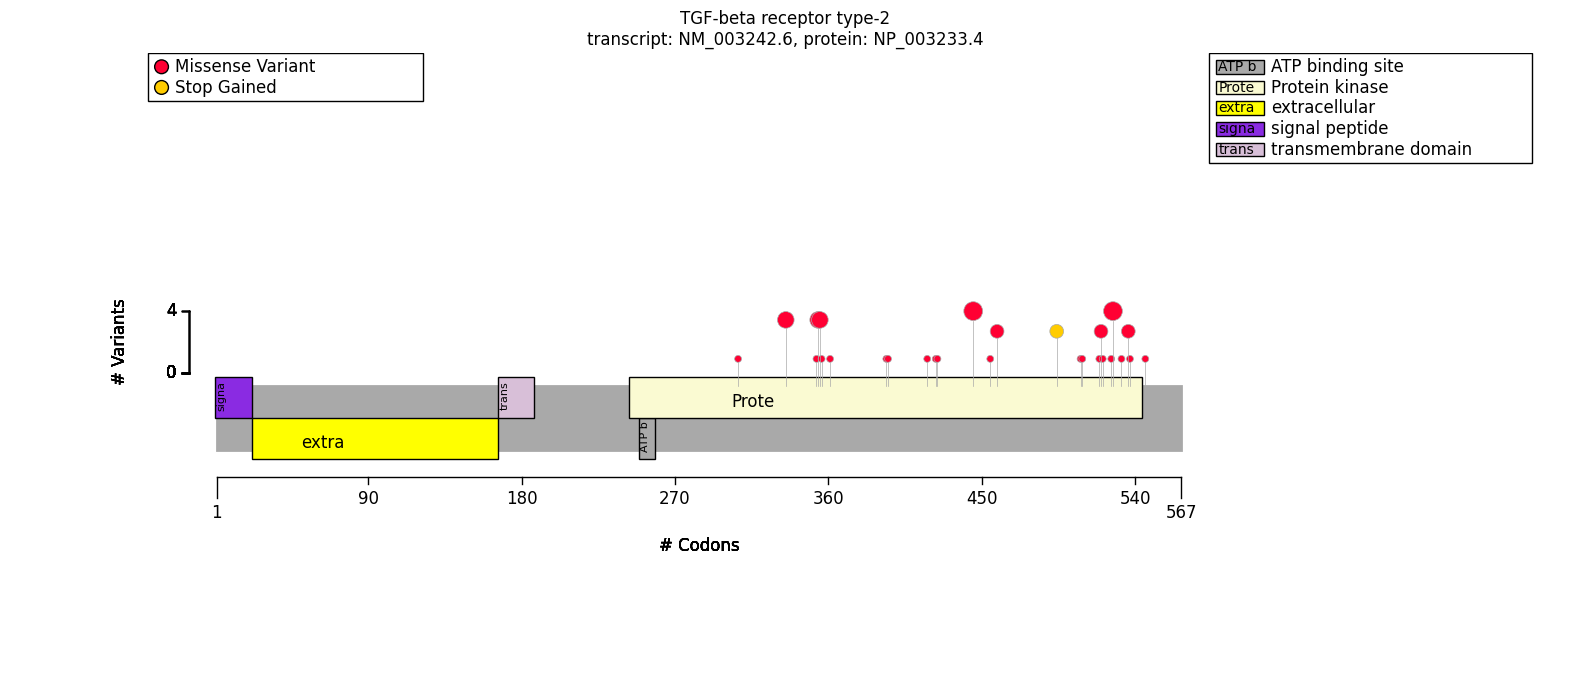

In [22]:
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id)
pvis = ProteinVisualizable(tx_coordinates=tx_coordinates, protein_meta=manual_protein_meta, cohort=cohort)
from gpsea.view import ProteinVisualizer

drawer = ProteinVisualizer()
ax = drawer.draw_fig(pvis=pvis)
fig = ax.get_figure()  # Get the figure object
fig.savefig('TGFBR2_gspea_domains.png', format='png') 